Imports
============

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
from dvn.data_utils import SyntheticData

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.cuda.get_device_name(0)

'TITAN Xp'

Firstly we load the data
============


In [3]:
patch_size=64

train_synthetic = SyntheticData(root_path="./data/train/", patch_size=patch_size)
val_synthetic = SyntheticData(root_path="./data/val/", patch_size=patch_size)

print("DONE")

DONE


Visualize part of the data
============

In [4]:
print("Train size: %i" % len(train_synthetic))
print("Validation size: %i" % len(val_synthetic))
print("Img size: ", train_synthetic[0][0].size())
print("Segmentation size: ", train_synthetic[0][1].size())

Train size: 110
Validation size: 26
Img size:  torch.Size([1, 64, 64, 64])
Segmentation size:  torch.Size([64, 64, 64])


Design network 
============

In [5]:
train_loader = torch.utils.data.DataLoader(train_synthetic, batch_size=10, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_synthetic, batch_size=2, shuffle=False, num_workers=1)

Train network
============

In [6]:
model = DeepVesselNetFCN()
model.to(device)

optim_args_SGD = {"lr": 1e-2, "weight_decay": 0, "momentum": 0.9, "nesterov":True}
optim_args_ADAM = {"lr": 1e-2, "weight_decay": 0}

solver = Solver(optim_args=optim_args_SGD, optim=torch.optim.SGD)
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=10)

START TRAIN
[Iteration 5/110] TRAIN loss: -6.364
[Iteration 10/110] TRAIN loss: -8.121
[Epoch 1/10] TRAIN acc/loss/dice: 0.960/-8.121/0.751
[Epoch 1/10] VAL   acc/loss/dice: 0.022/-3.642/0.017
[Iteration 16/110] TRAIN loss: -7.831
[Iteration 21/110] TRAIN loss: -8.058
[Epoch 2/10] TRAIN acc/loss/dice: 0.987/-8.058/0.872
[Epoch 2/10] VAL   acc/loss/dice: 0.509/-5.041/0.356
[Iteration 27/110] TRAIN loss: -8.668
[Iteration 32/110] TRAIN loss: -7.409
[Epoch 3/10] TRAIN acc/loss/dice: 0.992/-7.409/0.918
[Epoch 3/10] VAL   acc/loss/dice: 0.985/-7.403/0.813
[Iteration 38/110] TRAIN loss: -7.831
[Iteration 43/110] TRAIN loss: -8.900
[Epoch 4/10] TRAIN acc/loss/dice: 0.991/-8.900/0.895
[Epoch 4/10] VAL   acc/loss/dice: 0.992/-7.513/0.881
[Iteration 49/110] TRAIN loss: -7.863
[Iteration 54/110] TRAIN loss: -7.964
[Epoch 5/10] TRAIN acc/loss/dice: 0.993/-7.964/0.917
[Epoch 5/10] VAL   acc/loss/dice: 0.993/-7.528/0.896
[Iteration 60/110] TRAIN loss: -8.906
[Iteration 65/110] TRAIN loss: -8.069
[Ep

Test network
============

Visualization of network outputs
============


(1, 1, 64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(1, 1, 64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(1, 1, 64, 64, 64)
(64, 64, 64)
(64, 64, 64)


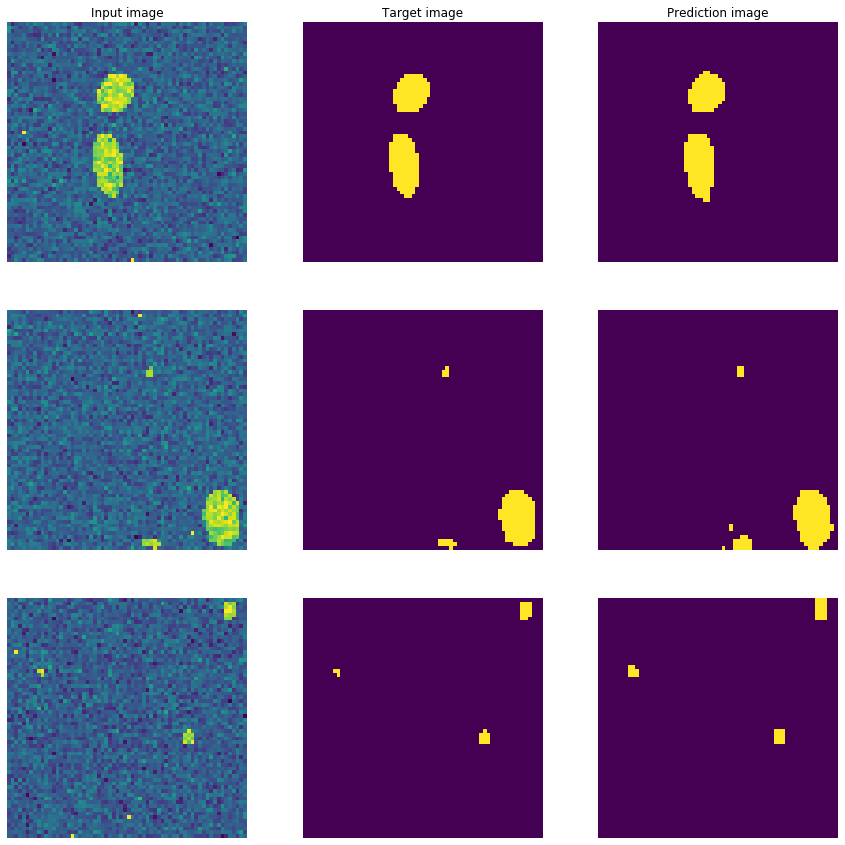

In [7]:
num_example_imgs = 3
plt.figure(figsize=(15, 5 * num_example_imgs))
model.eval()
for i, (inputs, targets) in enumerate(val_synthetic[:num_example_imgs]):
    
    inputs, targets = inputs.to(device, dtype=torch.float).unsqueeze(0), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)

    inputs, targets, preds = inputs.cpu().numpy(), targets.cpu().numpy(), preds.squeeze(0).cpu().numpy()
    print(inputs.shape)
    print(targets.shape)
    print(preds.shape)
    
    # inputs
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(preds[5])
    if i == 0:
        plt.title("Prediction image")

In [13]:
os.makedirs("models", exist_ok=True)
model.save("models/deepvesselnet.model")

Saving model... models/deepvesselnet.model
